# Langevin - PID mismatch

[GMM] Added .sample(n, seed) method.


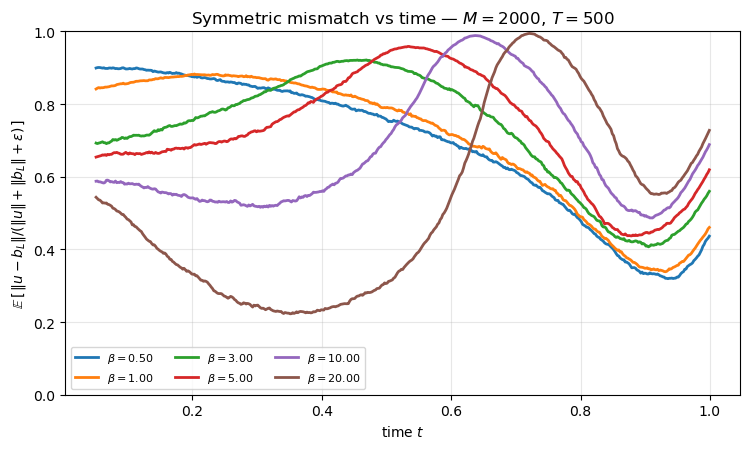

[saved] figs/rel_mismatch_sym_vs_time_M2000_T500.png


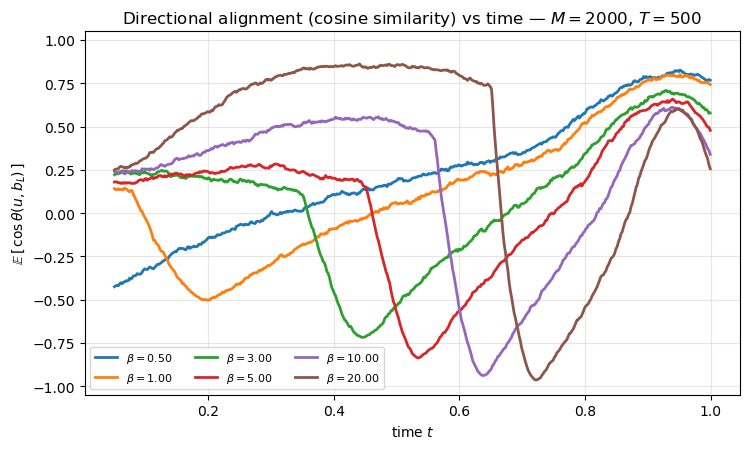

[saved] figs/rel_mismatch_cosine_vs_time_M2000_T500.png


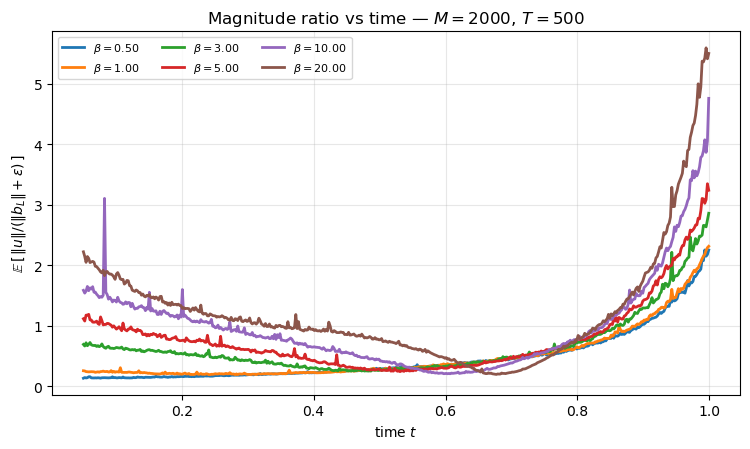

[saved] figs/rel_mismatch_ratio_vs_time_M2000_T500.png


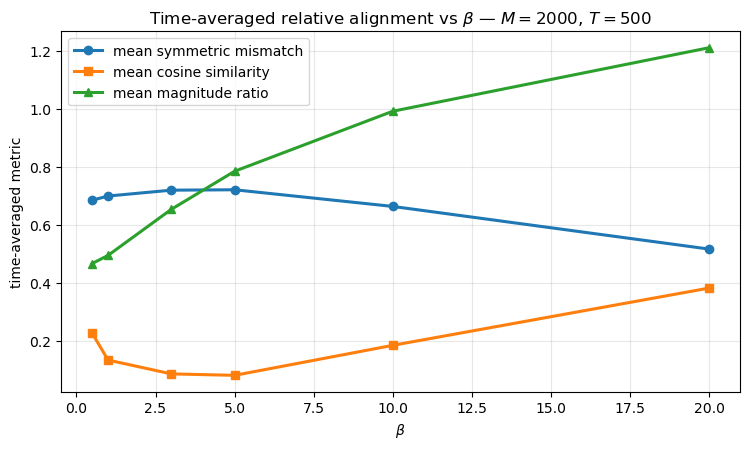

[saved] figs/rel_mismatch_timeavg_vs_beta_M2000_T500.png


In [1]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)


# =======================================================
# AdaPID vs Langevin (relative) alignment metrics
#   • Unit-diffusion convention:  dX = b dt + dW  ⇒  b_L = 1/2 ∇ log p_tar
#   • Metrics (all "relative"):
#       1) Symmetric mismatch  ρ_sym(t) = E[ ||u - b_L|| / (||u|| + ||b_L|| + ε) ] ∈ [0,1]
#       2) Cosine similarity   cos(t)   = E[ (u·b_L)/(||u|| ||b_L|| + ε) ] ∈ [-1,1]
#       3) Magnitude ratio     r(t)     = E[ ||u|| / (||b_L|| + ε) ]   (unbounded)
#   • Plots:
#       - Each metric vs time for multiple β (same colors across figures)
#       - Optional time average vs β summary (last figure)
# =======================================================
import numpy as np, math, os
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

# ---------- helper: stable isotropic-GMM score ∇ log p_tar(X) ----------
def _logsumexp(a, axis=-1):
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

def gmm_score_iso(X, gmm):
    """
    ∇_x log p_gmm(x) for isotropic components:
      p(x) = Σ_k π_k N(x | μ_k, σ_k^2 I)
    Returns array of shape (N,d).
    """
    X = np.asarray(X, float)               # (N,d)
    MU  = np.asarray(gmm.MU, float)       # (K,d)
    SIG = np.asarray(gmm.SIG, float)      # (K,)
    PI  = np.asarray(gmm.PI, float)       # (K,)
    N, d = X.shape
    K    = MU.shape[0]

    dx = X[:, None, :] - MU[None, :, :]   # (N,K,d)
    invs2 = 1.0 / (SIG**2)                # (K,)

    # unnormalized log responsibilities
    log_norm = -0.5 * d * np.log(2*np.pi*(SIG**2))   # (K,)
    sq = np.sum(dx*dx, axis=2)                       # (N,K)
    log_comp = (np.log(PI)[None,:] +
                log_norm[None,:] -
                0.5 * sq * invs2[None,:])           # (N,K)

    lse = _logsumexp(log_comp, axis=1)               # (N,)
    w   = np.exp(log_comp - lse[:, None])            # (N,K)

    contrib = -(dx * invs2[None,:,None])             # (N,K,d) = - (x-μ_k)/σ_k^2
    score = np.sum(w[:, :, None] * contrib, axis=1)  # (N,d)
    return score

# ---------- core: simulate once for a β and build time series of metrics ----------
def relative_mismatch_curves(beta, gmm, M=2000, T=500, seed=0, tmin_plot=0.0):
    """
    Simulate midpoint-EM AdaPID with constant β; compute per-time metrics:
      ρ_sym(t), cos(t), r(t). Returns dict with 't', 'rho', 'cos', 'ratio'
      (optionally trimmed to t ≥ tmin_plot for nicer plots).
    """
    rng = np.random.default_rng(seed)
    dt  = 1.0 / T
    d   = gmm.d

    sched = BetaSchedulePWC.constant(float(beta))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)   # interior sanity

    X = rng.normal(size=(M, d))
    rho = np.empty(T, float)
    csm = np.empty(T, float)
    rat = np.empty(T, float)

    eps = 1e-8
    for n in range(T):
        t   = (n + 0.5) / T
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X                        # AdaPID drift

        score = gmm_score_iso(X, gmm)                      # ∇ log p_tar
        bL    = 0.5 * score                                # Langevin drift (unit diffusion)

        un = np.linalg.norm(u, axis=1)
        bn = np.linalg.norm(bL, axis=1)
        dn = np.linalg.norm(u - bL, axis=1)

        rho[n] = float(np.mean(dn / (un + bn + eps)))      # symmetric mismatch ∈ [0,1]
        csm[n] = float(np.mean(np.sum(u*bL, axis=1) / (un*bn + eps)))  # cosine similarity
        rat[n] = float(np.mean(un / (bn + eps)))           # magnitude ratio

        # EM update
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    t_all = (np.arange(T) + 0.5) / T
    if tmin_plot > 0:
        keep = t_all >= float(tmin_plot)
        return {"t": t_all[keep], "rho": rho[keep], "cos": csm[keep], "ratio": rat[keep]}
    else:
        return {"t": t_all, "rho": rho, "cos": csm, "ratio": rat}

# ---------------- experiment settings ----------------

models = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]
gmm=regular

beta_list = [0.5, 1.0, 3.0, 5.0, 10.0, 20.0]
M_mis, T_mis = 2000, 500
seed_mis     = 20240919
tmin_plot    = 0.05   # hide the very first steps if scales are wild

# ---------------- run all β ----------------
mis = {}
for b in beta_list:
    mis[float(b)] = relative_mismatch_curves(
        beta=float(b), gmm=gmm, M=M_mis, T=T_mis, seed=seed_mis + int(13*b),
        tmin_plot=tmin_plot
    )

# ---------------- plots (3 figures) ----------------
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
col = {float(b): colors[i % len(colors)] for i,b in enumerate(beta_list)}

# (R1) Symmetric mismatch ρ_sym(t)
plt.figure(figsize=(7.6, 4.6))
for b in beta_list:
    s = mis[float(b)]
    plt.plot(s["t"], s["rho"], lw=2.0, color=col[float(b)], label=r"$\beta={:.2f}$".format(float(b)))
plt.xlabel(r"time $t$")
plt.ylabel(r"$\mathbb{E}\,[\,\|u-b_L\|/(\|u\|+\|b_L\|+\varepsilon)\,]$")
plt.title(r"Symmetric mismatch vs time — $M={},\,T={}$".format(M_mis, T_mis))
plt.ylim(0, 1)  # bounded by design
plt.grid(True, alpha=0.3); plt.legend(ncol=3, fontsize=8)
fn1 = "figs/rel_mismatch_sym_vs_time_M{}_T{}.png".format(M_mis, T_mis)
plt.tight_layout(); plt.savefig(fn1, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fn1)

# (R2) Cosine similarity cos(t)
plt.figure(figsize=(7.6, 4.6))
for b in beta_list:
    s = mis[float(b)]
    plt.plot(s["t"], s["cos"], lw=2.0, color=col[float(b)], label=r"$\beta={:.2f}$".format(float(b)))
plt.xlabel(r"time $t$")
plt.ylabel(r"$\mathbb{E}\,[\,\cos\theta(u,b_L)\,]$")
plt.title(r"Directional alignment (cosine similarity) vs time — $M={},\,T={}$".format(M_mis, T_mis))
plt.ylim(-1.05, 1.05)
plt.grid(True, alpha=0.3); plt.legend(ncol=3, fontsize=8)
fn2 = "figs/rel_mismatch_cosine_vs_time_M{}_T{}.png".format(M_mis, T_mis)
plt.tight_layout(); plt.savefig(fn2, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fn2)

# (R3) Magnitude ratio r(t)
plt.figure(figsize=(7.6, 4.6))
for b in beta_list:
    s = mis[float(b)]
    plt.plot(s["t"], s["ratio"], lw=2.0, color=col[float(b)], label=r"$\beta={:.2f}$".format(float(b)))
plt.xlabel(r"time $t$")
plt.ylabel(r"$\mathbb{E}\,[\,\|u\|/(\|b_L\|+\varepsilon)\,]$")
plt.title(r"Magnitude ratio vs time — $M={},\,T={}$".format(M_mis, T_mis))
plt.grid(True, alpha=0.3); plt.legend(ncol=3, fontsize=8)
fn3 = "figs/rel_mismatch_ratio_vs_time_M{}_T{}.png".format(M_mis, T_mis)
plt.tight_layout(); plt.savefig(fn3, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fn3)

# ---------------- optional: time-averaged summaries vs β ----------------
rho_avg = []
cos_avg = []
rat_avg = []
for b in beta_list:
    s = mis[float(b)]
    rho_avg.append(float(np.mean(s["rho"])))
    cos_avg.append(float(np.mean(s["cos"])))
    rat_avg.append(float(np.mean(s["ratio"])))

beta_arr = np.array(beta_list, float)

plt.figure(figsize=(7.6, 4.6))
plt.plot(beta_arr, rho_avg, lw=2.2, marker="o", label=r"mean symmetric mismatch")
plt.plot(beta_arr, cos_avg, lw=2.2, marker="s", label=r"mean cosine similarity")
plt.plot(beta_arr, rat_avg, lw=2.2, marker="^", label=r"mean magnitude ratio")
plt.xlabel(r"$\beta$")
plt.ylabel(r"time-averaged metric")
plt.title(r"Time-averaged relative alignment vs $\beta$ — $M={},\,T={}$".format(M_mis, T_mis))
plt.grid(True, alpha=0.3); plt.legend()
fn4 = "figs/rel_mismatch_timeavg_vs_beta_M{}_T{}.png".format(M_mis, T_mis)
plt.tight_layout(); plt.savefig(fn4, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fn4)


# Three panel version - for three models

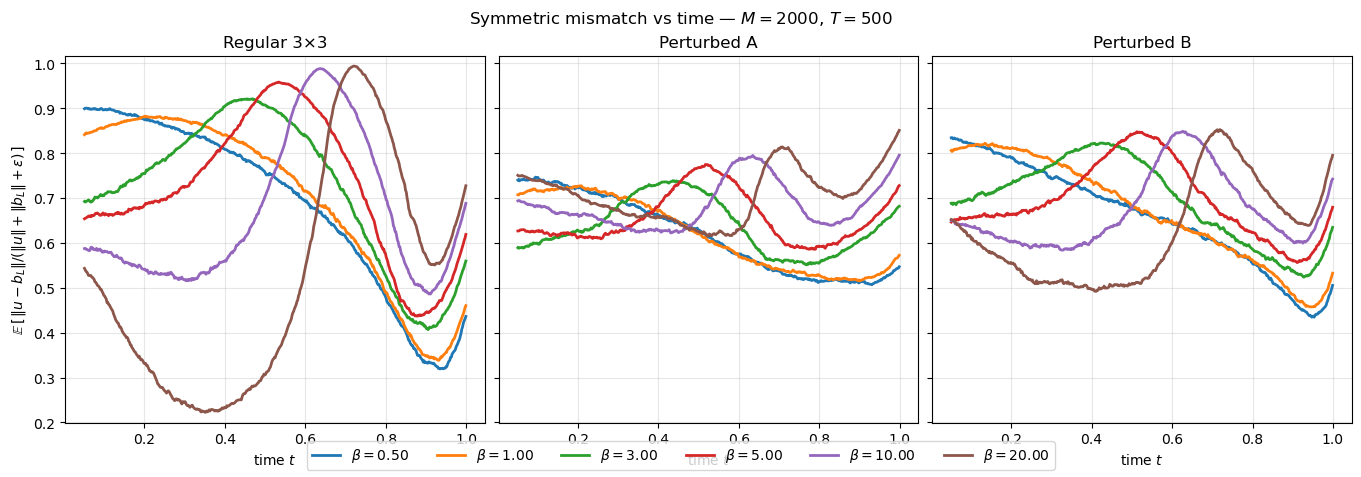

[saved] figs/rel_mismatch_sym_vs_time_3panels_M2000_T500.png


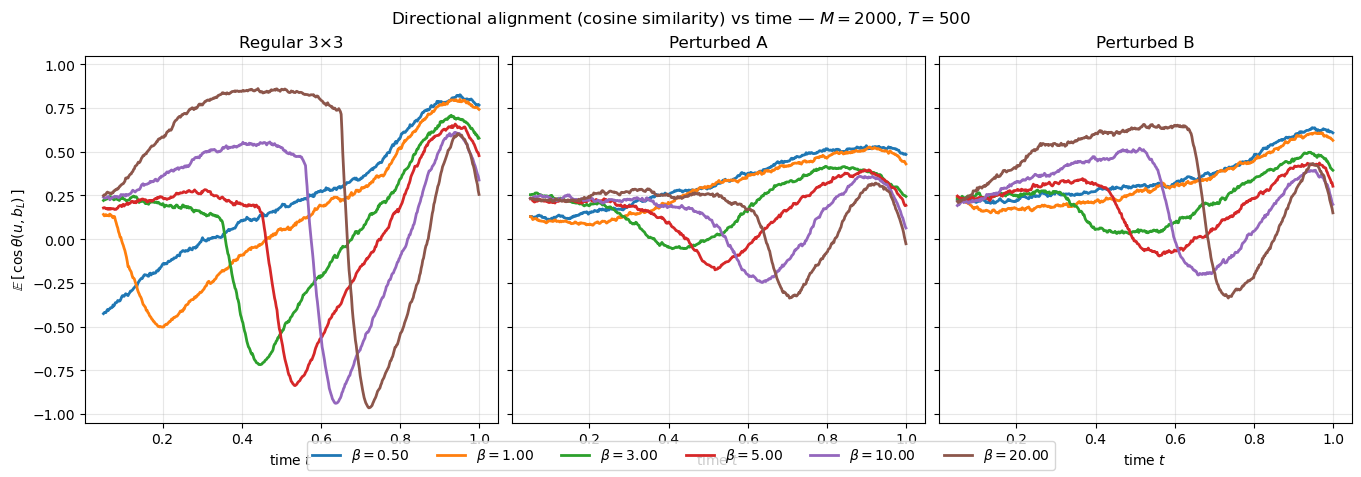

[saved] figs/rel_mismatch_cosine_vs_time_3panels_M2000_T500.png


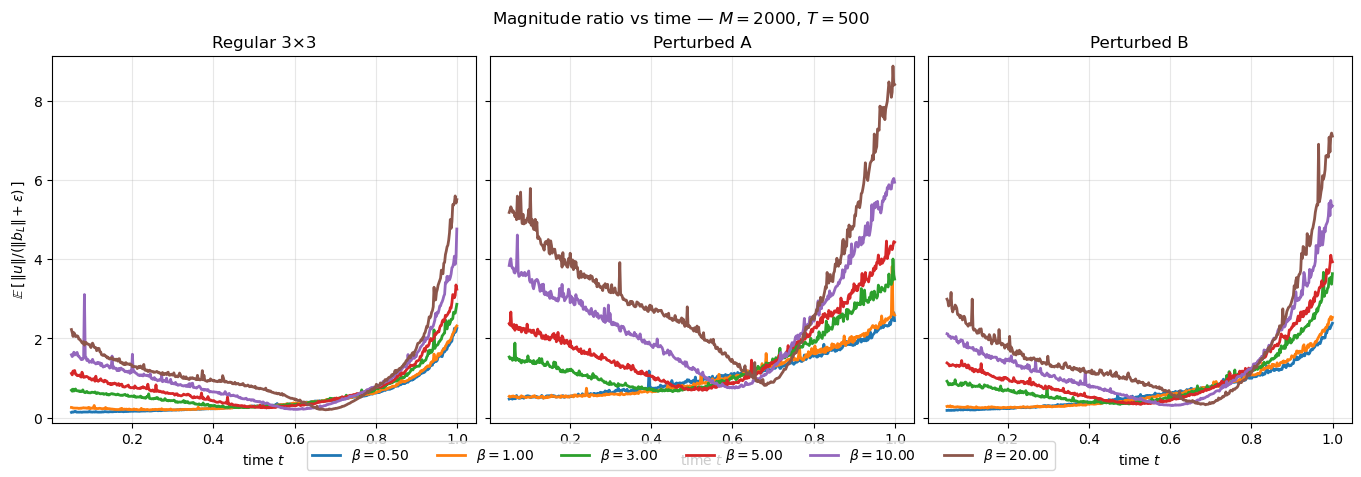

[saved] figs/rel_mismatch_ratio_vs_time_3panels_M2000_T500.png


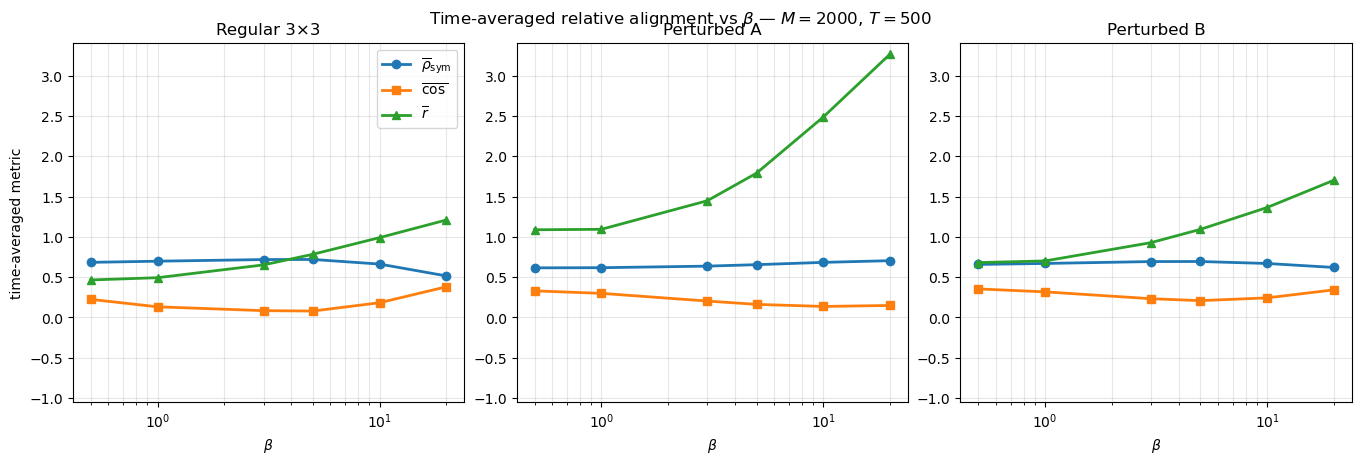

[saved] figs/rel_mismatch_timeavg_vs_beta_3panels_M2000_T500.png


In [3]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)

# =======================================================
# AdaPID vs Langevin (relative) alignment metrics — 3 panels (Regular, PertA, PertB)
#   • Unit-diffusion convention:  dX = b dt + dW  ⇒  b_L = 1/2 ∇ log p_tar
#   • Metrics (all "relative"):
#       1) Symmetric mismatch  ρ_sym(t) = E[ ||u - b_L|| / (||u|| + ||b_L|| + ε) ] ∈ [0,1]
#       2) Cosine similarity   cos(t)   = E[ (u·b_L)/(||u|| ||b_L|| + ε) ] ∈ [-1,1]
#       3) Magnitude ratio     r(t)     = E[ ||u|| / (||b_L|| + ε) ]   (unbounded)
#   • Plots (now 3 panels each): one panel per GMM; same β colors in all panels.
#   • Axes limits: same y-scale across the 3 panels of each figure.
# =======================================================

# ---------- helper: stable isotropic-GMM score ∇ log p_tar(X) ----------
def _logsumexp(a, axis=-1):
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

def gmm_score_iso(X, gmm):
    """
    ∇_x log p_gmm(x) for isotropic components:
      p(x) = Σ_k π_k N(x | μ_k, σ_k^2 I)
    Returns array of shape (N,d).
    """
    X = np.asarray(X, float)               # (N,d)
    MU  = np.asarray(gmm.MU, float)       # (K,d)
    SIG = np.asarray(gmm.SIG, float)      # (K,)
    PI  = np.asarray(gmm.PI, float)       # (K,)
    N, d = X.shape
    dx = X[:, None, :] - MU[None, :, :]   # (N,K,d)
    invs2 = 1.0 / (SIG**2)                # (K,)

    # unnormalized log responsibilities
    log_norm = -0.5 * d * np.log(2*np.pi*(SIG**2))   # (K,)
    sq = np.sum(dx*dx, axis=2)                       # (N,K)
    log_comp = (np.log(PI)[None,:] +
                log_norm[None,:] -
                0.5 * sq * invs2[None,:])           # (N,K)

    lse = _logsumexp(log_comp, axis=1)               # (N,)
    w   = np.exp(log_comp - lse[:, None])            # (N,K)

    contrib = -(dx * invs2[None,:,None])             # (N,K,d) = - (x-μ_k)/σ_k^2
    score = np.sum(w[:, :, None] * contrib, axis=1)  # (N,d)
    return score

# ---------- core: simulate once for a β and build time series of metrics ----------
def relative_mismatch_curves(beta, gmm, M=2000, T=500, seed=0, tmin_plot=0.0):
    """
    Simulate midpoint-EM AdaPID with constant β; compute per-time metrics:
      ρ_sym(t), cos(t), r(t). Returns dict with 't', 'rho', 'cos', 'ratio'
      (optionally trimmed to t ≥ tmin_plot).
    """
    rng = np.random.default_rng(seed)
    dt  = 1.0 / T
    d   = gmm.d

    sched = BetaSchedulePWC.constant(float(beta))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)   # interior sanity

    X = rng.normal(size=(M, d))
    rho = np.empty(T, float)
    csm = np.empty(T, float)
    rat = np.empty(T, float)

    eps = 1e-8
    for n in range(T):
        t   = (n + 0.5) / T
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X                        # AdaPID drift

        score = gmm_score_iso(X, gmm)                      # ∇ log p_tar
        bL    = 0.5 * score                                # Langevin drift (unit diffusion)

        un = np.linalg.norm(u, axis=1)
        bn = np.linalg.norm(bL, axis=1)
        dn = np.linalg.norm(u - bL, axis=1)

        rho[n] = float(np.mean(dn / (un + bn + eps)))      # symmetric mismatch ∈ [0,1]
        csm[n] = float(np.mean(np.sum(u*bL, axis=1) / (un*bn + eps)))  # cosine similarity
        rat[n] = float(np.mean(un / (bn + eps)))           # magnitude ratio

        # EM update
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    t_all = (np.arange(T) + 0.5) / T
    if tmin_plot > 0:
        keep = t_all >= float(tmin_plot)
        return {"t": t_all[keep], "rho": rho[keep], "cos": csm[keep], "ratio": rat[keep]}
    else:
        return {"t": t_all, "rho": rho, "cos": csm, "ratio": rat}

# ---------------- experiment settings ----------------
models = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]

beta_list = [0.5, 1.0, 3.0, 5.0, 10.0, 20.0]
M_mis, T_mis = 2000, 500
seed_mis     = 20240919
tmin_plot    = 0.05   # hide the very first steps if scales are wild

# ---------------- run all β for each model ----------------
# mis_by_model[(name, beta)] = dict(t, rho, cos, ratio)
mis_by_model = {}
for mi, (name, gmm) in enumerate(models):
    for b in beta_list:
        mis_by_model[(name, float(b))] = relative_mismatch_curves(
            beta=float(b), gmm=gmm, M=M_mis, T=T_mis, seed=seed_mis + 791*mi + int(13*b),
            tmin_plot=tmin_plot
        )

# consistent colors across all panels
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
col = {float(b): colors[i % len(colors)] for i,b in enumerate(beta_list)}

# ---------------- helper to get common y-lims across 3 panels ----------------
def common_ylim(metric_key):
    ymin, ymax = +np.inf, -np.inf
    for name, _ in models:
        for b in beta_list:
            s = mis_by_model[(name, float(b))]
            y = np.asarray(s[metric_key], float)
            if y.size:
                ymin = min(ymin, float(np.nanmin(y)))
                ymax = max(ymax, float(np.nanmax(y)))
    if not np.isfinite(ymin) or not np.isfinite(ymax):
        return None
    if ymax - ymin < 1e-9:  # avoid degenerate ranges
        pad = 1e-3
        return (ymin - pad, ymax + pad)
    pad = 0.03 * (ymax - ymin)
    return (ymin - pad, ymax + pad)

# =========================================================
# (R1) ρ_sym(t) — 3 panels (shared y across panels)
# =========================================================
fig, axs = plt.subplots(1, 3, figsize=(13.5, 4.4), constrained_layout=True, sharex=True, sharey=True)
ylim_rho = common_ylim("rho")
for ax, (name, _gmm) in zip(axs, models):
    for b in beta_list:
        s = mis_by_model[(name, float(b))]
        ax.plot(s["t"], s["rho"], lw=2.0, color=col[float(b)], label=fr"$\beta={float(b):.2f}$")
    ax.set_title(name); ax.grid(True, alpha=0.3)
    ax.set_xlabel(r"time $t$")
axs[0].set_ylabel(r"$\mathbb{E}\,[\,\|u-b_L\|/(\|u\|+\|b_L\|+\varepsilon)\,]$")
if ylim_rho is not None:
    for ax in axs: ax.set_ylim(*ylim_rho)
# put legend once (top center)
handles = [plt.Line2D([0],[0], color=col[float(b)], lw=2.0, label=fr"$\beta={float(b):.2f}$") for b in beta_list]
fig.legend(handles=handles, loc="lower center", ncol=min(6, len(beta_list)), frameon=True)
fig.suptitle(fr"Symmetric mismatch vs time — $M={M_mis},\,T={T_mis}$", y=1.05)
fn1 = f"figs/rel_mismatch_sym_vs_time_3panels_M{M_mis}_T{T_mis}.png"
fig.savefig(fn1, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fn1)

# =========================================================
# (R2) cosine similarity — 3 panels (shared y across panels)
# =========================================================
fig, axs = plt.subplots(1, 3, figsize=(13.5, 4.4), constrained_layout=True, sharex=True, sharey=True)
ylim_cos = (-1.05, 1.05)  # fixed theoretical range
for ax, (name, _gmm) in zip(axs, models):
    for b in beta_list:
        s = mis_by_model[(name, float(b))]
        ax.plot(s["t"], s["cos"], lw=2.0, color=col[float(b)], label=fr"$\beta={float(b):.2f}$")
    ax.set_title(name); ax.grid(True, alpha=0.3); ax.set_xlabel(r"time $t$")
for ax in axs: ax.set_ylim(*ylim_cos)
axs[0].set_ylabel(r"$\mathbb{E}\,[\,\cos\theta(u,b_L)\,]$")
handles = [plt.Line2D([0],[0], color=col[float(b)], lw=2.0, label=fr"$\beta={float(b):.2f}$") for b in beta_list]
fig.legend(handles=handles, loc="lower center", ncol=min(6, len(beta_list)), frameon=True)
fig.suptitle(fr"Directional alignment (cosine similarity) vs time — $M={M_mis},\,T={T_mis}$", y=1.05)
fn2 = f"figs/rel_mismatch_cosine_vs_time_3panels_M{M_mis}_T{T_mis}.png"
fig.savefig(fn2, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fn2)

# =========================================================
# (R3) magnitude ratio — 3 panels (shared y across panels)
# =========================================================
fig, axs = plt.subplots(1, 3, figsize=(13.5, 4.4), constrained_layout=True, sharex=True, sharey=True)
ylim_rat = common_ylim("ratio")
for ax, (name, _gmm) in zip(axs, models):
    for b in beta_list:
        s = mis_by_model[(name, float(b))]
        ax.plot(s["t"], s["ratio"], lw=2.0, color=col[float(b)], label=fr"$\beta={float(b):.2f}$")
    ax.set_title(name); ax.grid(True, alpha=0.3); ax.set_xlabel(r"time $t$")
axs[0].set_ylabel(r"$\mathbb{E}\,[\,\|u\|/(\|b_L\|+\varepsilon)\,]$")
if ylim_rat is not None:
    for ax in axs: ax.set_ylim(*ylim_rat)
handles = [plt.Line2D([0],[0], color=col[float(b)], lw=2.0, label=fr"$\beta={float(b):.2f}$") for b in beta_list]
fig.legend(handles=handles, loc="lower center", ncol=min(6, len(beta_list)), frameon=True)
fig.suptitle(fr"Magnitude ratio vs time — $M={M_mis},\,T={T_mis}$", y=1.05)
fn3 = f"figs/rel_mismatch_ratio_vs_time_3panels_M{M_mis}_T{T_mis}.png"
fig.savefig(fn3, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fn3)

# =========================================================
# (R4) time-averaged summaries vs β — 3 panels (per model)
#       • Each panel plots (ρ̄, cos̄, r̄) vs β
# =========================================================
rho_avg_by_model = {}
cos_avg_by_model = {}
rat_avg_by_model = {}
for name, _gmm in models:
    rho_avg = []; cos_avg = []; rat_avg = []
    for b in beta_list:
        s = mis_by_model[(name, float(b))]
        rho_avg.append(float(np.mean(s["rho"])))
        cos_avg.append(float(np.mean(s["cos"])))
        rat_avg.append(float(np.mean(s["ratio"])))
    rho_avg_by_model[name] = np.array(rho_avg, float)
    cos_avg_by_model[name] = np.array(cos_avg, float)
    rat_avg_by_model[name] = np.array(rat_avg, float)

# common y-lims per metric across panels for the summary
def common_ylim_summary(arrs):
    ymin, ymax = +np.inf, -np.inf
    for A in arrs:
        if A.size:
            ymin = min(ymin, float(np.nanmin(A)))
            ymax = max(ymax, float(np.nanmax(A)))
    if not np.isfinite(ymin) or not np.isfinite(ymax):
        return None
    if ymax - ymin < 1e-9:
        pad = 1e-3
        return (ymin - pad, ymax + pad)
    pad = 0.05*(ymax - ymin)
    return (ymin - pad, ymax + pad)

ylim_rho_avg = common_ylim_summary(list(rho_avg_by_model.values()))
ylim_cos_avg = (-1.05, 1.05)
ylim_rat_avg = common_ylim_summary(list(rat_avg_by_model.values()))

fig, axs = plt.subplots(1, 3, figsize=(13.5, 4.4), constrained_layout=True, sharex=True)
for ax, (name, _gmm) in zip(axs, models):
    ax.plot(beta_list, rho_avg_by_model[name], lw=2.0, marker="o", label=r"$\overline{\rho}_{\mathrm{sym}}$")
    ax.plot(beta_list, cos_avg_by_model[name], lw=2.0, marker="s", label=r"$\overline{\cos}$")
    ax.plot(beta_list, rat_avg_by_model[name], lw=2.0, marker="^", label=r"$\overline{r}$")
    ax.set_xscale("log")
    ax.set_title(name); ax.grid(True, which="both", alpha=0.3)
    ax.set_xlabel(r"$\beta$")
axs[0].set_ylabel("time-averaged metric")

# apply common y-lims per metric by plotting order (we mixed 3 curves; use union)
# To keep consistent scale across panels, take global min/max across all three curves:
if ylim_rho_avg and ylim_rat_avg:
    ymin = min(ylim_rho_avg[0], ylim_cos_avg[0], ylim_rat_avg[0])
    ymax = max(ylim_rho_avg[1], ylim_cos_avg[1], ylim_rat_avg[1])
    for ax in axs: ax.set_ylim(ymin, ymax)
# legend once
axs[0].legend(frameon=True, loc="best")
fig.suptitle(fr"Time-averaged relative alignment vs $\beta$ — $M={M_mis},\,T={T_mis}$", y=1.02)
fn4 = f"figs/rel_mismatch_timeavg_vs_beta_3panels_M{M_mis}_T{T_mis}.png"
fig.savefig(fn4, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fn4)
